<a href="https://colab.research.google.com/github/s-choung/Simulation_tutorials/blob/main/handson5_MD_setup_and_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade asap3
!pip install ase


In [ ]:
!sudo apt-get install povray  ## visulization program

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-povray libsdl1.2debian povray-includes
Suggested packages:
  povray-doc povray-examples
The following NEW packages will be installed:
  fonts-povray libsdl1.2debian povray povray-includes
0 upgraded, 4 newly installed, 0 to remove and 49 not upgraded.
Need to get 1,792 kB of archives.
After this operation, 5,199 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-povray all 1:3.7.0.10-1 [70.0 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libsdl1.2debian amd64 1.2.15+dfsg2-6 [177 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 povray amd64 1:3.7.0.10-1 [1,312 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 povray-includes all 1:3.7.0.10-1 [233 kB]
Fetched 1,792 kB in 1s (1,386 kB/s)
debconf: unable to initialize frontend: Dialo

In [ ]:
import os
import shutil
from ase.io import write  # Import the write function from ASE
from PIL import Image
from IPython.display import display  # Import display for Jupyter Notebooks


def visual(structure, max_size=(200, 200), stretch_y=1.0, rotation='15z,-90x', png_save_path='./'):
    renderer = write('./temp.pov', structure, rotation=rotation)
    renderer.render()
    image_path = './temp.png'
    img = Image.open(image_path)

    # Calculate new size with stretch factor
    new_size = (max_size[0], int(max_size[1] * stretch_y))
    img = img.resize(new_size, Image.LANCZOS)
    display(img)

    # Move files to output directory
    files = ['./temp.ini', './temp.pov', './temp.png']
    destination = './output/'

    # Ensure destination directory exists
    os.makedirs(destination, exist_ok=True)

    for file in files:
        # Remove the file in the destination directory if it exists
        if os.path.isfile(os.path.join(destination, os.path.basename(file))):
            os.remove(os.path.join(destination, os.path.basename(file)))

        if file == './temp.png':
            new_file_name = png_save_path + f'temp.png'
        else:
            new_file_name = os.path.basename(file)
        shutil.move(file, os.path.join(destination, new_file_name))


In [ ]:
import os
from asap3 import EMT
calculator = EMT()

from ase.build import bulk
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution,Stationary
from ase.md.verlet import VelocityVerlet
from ase.md import MDLogger
from ase import units
from time import perf_counter
import numpy as np

# Set up a fcc-Al crystal
atoms = bulk("Al","fcc",a=4.3,cubic=True)
atoms.pbc = True
atoms *= 3
print("atoms = ",atoms)

# Set calculator (EMT in this case)
atoms.calc = calculator

# input parameters
time_step    = 1.0      # MD step size in fsec
temperature  = 1600     # Temperature in Kelvin
num_md_steps = 100000   # Total number of MD steps
num_interval = 1000     # Print out interval for .log and .traj

# Set the momenta corresponding to the given "temperature"
MaxwellBoltzmannDistribution(atoms, temperature_K=temperature,force_temp=True)
Stationary(atoms)  # Set zero total momentum to avoid drifting

# Set output filenames
output_filename = "./test"
log_filename = output_filename + ".log"
print("log_filename = ",log_filename)
traj_filename = output_filename + ".traj"
print("traj_filename = ",traj_filename)

# Remove old files if they exist
if os.path.exists(log_filename): os.remove(log_filename)
if os.path.exists(traj_filename): os.remove(traj_filename)

# Define the MD dynamics class object
dyn = VelocityVerlet(atoms,
                     time_step * units.fs,
                     trajectory = traj_filename,
                     loginterval=num_interval
                    )

# Print statements
def print_dyn():
    imd = dyn.get_number_of_steps()
    time_md = time_step*imd
    etot  = atoms.get_total_energy()
    ekin  = atoms.get_kinetic_energy()
    epot  = atoms.get_potential_energy()
    temp_K = atoms.get_temperature()
    print(f"   {imd: >3}     {etot:.9f}     {ekin:.9f}    {epot:.9f}   {temp_K:.2f}")

dyn.attach(print_dyn, interval=num_interval)

# Set MD logger
dyn.attach(MDLogger(dyn, atoms, log_filename, header=True, stress=False,peratom=False, mode="w"), interval=num_interval)

# Now run MD simulation
print(f"\n    imd     Etot(eV)    Ekin(eV)    Epot(eV)    T(K)")
dyn.run(num_md_steps)

print("\nNormal termination of the MD run!")

atoms =  Atoms(symbols='Al108', pbc=True, cell=[12.899999999999999, 12.899999999999999, 12.899999999999999])
log_filename =  ./test.log
traj_filename =  ./test.traj

    imd     Etot(eV)    Ekin(eV)    Epot(eV)    T(K)
     0     32.139701294     22.336120234    9.803581060   1600.00
   1000     32.144122414     11.214465459    20.929656954   803.32
   2000     32.144914767     9.214867283    22.930047484   660.09
   3000     32.144866302     9.602403090    22.542463212   687.85
   4000     32.144618168     10.550600856    21.594017312   755.77
   5000     32.144373066     10.858109736    21.286263330   777.80
   6000     32.144739449     10.902646797    21.242092652   780.99
   7000     32.144359884     11.657074664    20.487285220   835.03
   8000     32.144895046     10.137860702    22.007034344   726.20
   9000     32.144350775     11.534081982    20.610268793   826.22
   10000     32.144516207     10.811415697    21.333100510   774.45
   11000     32.145097210     9.744354093    2

In [ ]:
import pandas as pd

df = pd.read_csv(log_filename, delim_whitespace=True)
df

,Time[ps],Etot[eV],Epot[eV],Ekin[eV],T[K]
0,0.0,32.140,9.804,22.336,1600.0
1,1.0,32.144,20.930,11.214,803.3
2,2.0,32.145,22.930,9.215,660.1
3,3.0,32.145,22.542,9.602,687.8
4,4.0,32.145,21.594,10.551,755.8
...,...,...,...,...,...
96,96.0,32.144,22.532,9.612,688.5
97,97.0,32.144,20.735,11.409,817.3
98,98.0,32.144,21.485,10.660,763.6
99,99.0,32.144,22.273,9.872,707.1


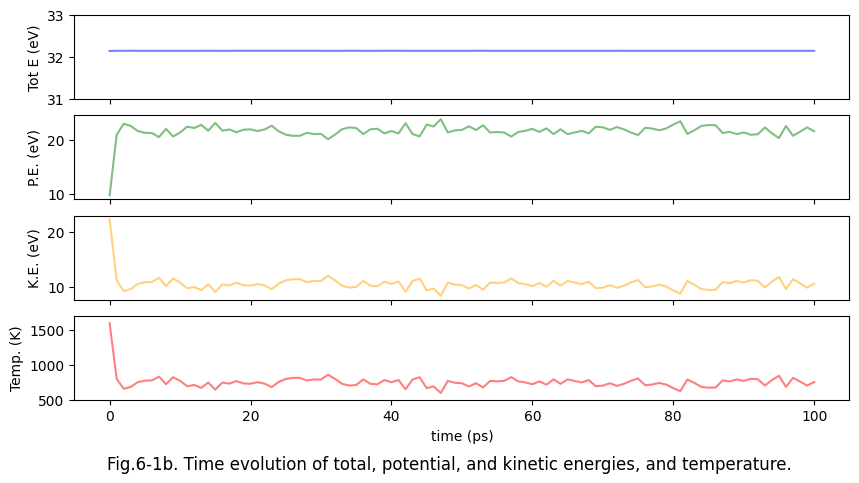

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(4, 1, 1)
ax1.set_xticklabels([])
ax1.set_ylabel('Tot E (eV)')
ax1.set_ylim([31.,33.])
ax1.plot(df["Time[ps]"], df["Etot[eV]"], color="blue",alpha=0.5)

ax2 = fig.add_subplot(4, 1, 2)
ax2.set_xticklabels([])
ax2.set_ylabel('P.E. (eV)')
ax2.plot(df["Time[ps]"], df["Epot[eV]"], color="green",alpha=0.5)

ax3 = fig.add_subplot(4, 1, 3)
ax3.set_xticklabels([])
ax3.set_ylabel('K.E. (eV)')
ax3.plot(df["Time[ps]"], df["Ekin[eV]"], color="orange",alpha=0.5)

ax4 = fig.add_subplot(4, 1, 4)
ax4.set_xlabel('time (ps)')
ax4.set_ylabel('Temp. (K)')
ax4.plot(df["Time[ps]"], df["T[K]"], color="red",alpha=0.5)
ax4.set_ylim([500., 1700])

fig.suptitle("Time evolution of total, potential, and kinetic energies, and temperature.", y=0)

#plt.savefig("6-1_liquid-Al_NVE_1.0fs_test_E_vs_t.png")  # <- Use if saving to an image file is desired
plt.show()

In [ ]:
# flake8: noqa
import numpy as np

from ase import Atoms
from ase.calculators.gulp import GULP, Conditions

cluster = Atoms(symbols='O4SiOSiO2SiO2SiO2SiOSiO2SiO3SiO3H8',
                pbc=np.array([False, False, False], dtype=bool),
                cell=np.array(
                    [[0., 0., 0.],
                     [0., 0., 0.],
                        [0., 0., 0.]]),
                positions=np.array(
                    [[-1.444348, -0.43209, -2.054785],
                     [-0.236947, 2.98731, 1.200025],
                        [3.060238, -1.05911, 0.579909],
                        [2.958277, -3.289076, 2.027579],
                        [-0.522747, 0.847624, -2.47521],
                        [-2.830486, -2.7236, -2.020633],
                        [-0.764328, -1.251141, 1.402431],
                        [3.334801, 0.041643, -4.168601],
                        [-1.35204, -2.009562, 0.075892],
                        [-1.454655, -1.985635, -1.554533],
                        [0.85504, 0.298129, -3.159972],
                        [1.75833, 1.256026, 0.690171],
                        [2.376446, -0.239522, -2.881245],
                        [1.806515, -4.484208, -2.686456],
                        [-0.144193, -2.74503, -2.177778],
                        [0.167583, 1.582976, 0.47998],
                        [-1.30716, 1.796853, -3.542121],
                        [1.441364, -3.072993, -1.958788],
                        [-1.694171, -1.558913, 2.704219],
                        [4.417516, 1.263796, 0.563573],
                        [3.066366, 0.49743, 0.071898],
                        [-0.704497, 0.351869, 1.102318],
                        [2.958884, 0.51505, -1.556651],
                        [1.73983, -3.161794, -0.356577],
                        [2.131519, -2.336982, 0.996026],
                        [0.752313, -1.788039, 1.687183],
                        [-0.142347, 1.685301, -1.12086],
                        [2.32407, -1.845905, -2.588202],
                        [-2.571557, -1.937877, 2.604727],
                        [2.556369, -4.551103, -3.2836],
                        [3.032586, 0.591698, -4.896276],
                        [-1.67818, 2.640745, -3.27092],
                        [5.145483, 0.775188, 0.95687],
                        [-2.81059, -3.4492, -2.650319],
                        [2.558023, -3.594544, 2.845928],
                        [0.400993, 3.469148, 1.733289]]))


c = Conditions(cluster)
c.min_distance_rule('O', 'H', ifcloselabel1='O2',
                    ifcloselabel2='H', elselabel1='O1')
calc = GULP(keywords='conp', shel=['O1', 'O2'], conditions=c)

# Single point calculation
cluster.calc = calc
print(cluster.get_potential_energy())

# Optimization using the internal optimizer of GULP
calc.set(keywords='conp opti')
opt = calc.get_optimizer(cluster)
opt.run(fmax=0.05)
print(cluster.get_potential_energy())

RuntimeError: Be sure to have set correctly $GULP_LIB or to have the force field library.